# Inital imports

In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

seed = 777
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.3.1
0.4.2


In [3]:
!nvidia-smi

Sun Dec  8 15:12:53 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!pip install Pillow==6.2.1

# Hyper-Parameters for training

In [ ]:
N_EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001


# Check versions of crucial libraries

In [6]:
print(torch.__version__)
print(np.__version__)
print(torchvision.__version__)
print(PIL.__version__)

1.3.1
1.17.4
0.4.2
6.2.1


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

#Training
n_training_samples = 20000
train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))

#Preprocessed Training
n_pre_training_samples = n_training_samples / BATCH_SIZE
train_pre_sampler = SubsetRandomSampler(np.arange(n_pre_training_samples, dtype=np.int64))

#Validation
n_val_samples = 5000
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

#Test
n_test_samples = 5000
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

In [ ]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size, train_set):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_sampler, num_workers=0)
    return(train_loader)

In [ ]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_preprocessed_train_loader(batch_size, train_set):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                           sampler=train_pre_sampler, num_workers=0)
    return(train_loader)

# Preprocess the data with augmentation.
To spare the augmentation from being applied on every loading during training, preprocessing is done once.
With this, the random effect of some augmentation is gone to a static one though.

In [11]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Copy the data over to colab
!cp -r /content/gdrive/'My Drive'/preprocessed_data.zip .

In [13]:
#unpack the archive
!unzip preprocessed_data.zip

Archive:  preprocessed_data.zip
replace preprocessed_data/autoaugment/0? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: preprocessed_data/autoaugment/0  
  inflating: preprocessed_data/autoaugment/1  
  inflating: preprocessed_data/autoaugment/10  
  inflating: preprocessed_data/autoaugment/100  
  inflating: preprocessed_data/autoaugment/101  
  inflating: preprocessed_data/autoaugment/102  
  inflating: preprocessed_data/autoaugment/103  
  inflating: preprocessed_data/autoaugment/104  
  inflating: preprocessed_data/autoaugment/105  
  inflating: preprocessed_data/autoaugment/106  
  inflating: preprocessed_data/autoaugment/107  
  inflating: preprocessed_data/autoaugment/108  
  inflating: preprocessed_data/autoaugment/109  
  inflating: preprocessed_data/autoaugment/11  
  inflating: preprocessed_data/autoaugment/110  
  inflating: preprocessed_data/autoaugment/111  
  inflating: preprocessed_data/autoaugment/112  
  inflating: preprocessed_data/autoaugment/113  
  inflating

In [14]:
#Check if preprocessed directories are mounted
!ls preprocessed_data


autoaugment  imgaug  norm  pytorch


In [ ]:

from torch.autograd import Variable
import torch.nn.functional as F

class SmallNet(torch.nn.Module):
    
    #Our batch shape for input x is (3, 32, 32)
    
    def __init__(self):
        super(SmallNet, self).__init__()
        
        #Input channels = 3, output channels = 18
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        
        self.conv1_bn = torch.nn.BatchNorm2d(16)

        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
        
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        
        self.conv3_bn = torch.nn.BatchNorm2d(32)
        
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(32 * 8 * 8, 1024)
        
        self.drop_layer = torch.nn.Dropout(p=0.5)
        
        #64 input features, 10 output features for our 10 defined classes
        self.fc2 = torch.nn.Linear(1024, 10)
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from 
        x = F.relu(self.conv1(x))
        x = self.drop_layer(x)

        x = self.conv1_bn(x)

        #Size changes from 
        x = self.pool1(x)
        
        x = F.relu(self.conv2(x))
        x = self.drop_layer(x)
        
        x = F.relu(self.conv3(x))
        x = self.drop_layer(x)
        
        x = self.conv3_bn(x)
        
        x = self.pool2(x)
            
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from 
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 2048)
        
        #Computes the activation of the first fully connected layer
        #Size changes from 
        x = F.relu(self.fc1(x))
        x = self.drop_layer(x)
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from
        x = self.fc2(x)


        return(x)

In [16]:
transform_tensor_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_set = torchvision.datasets.CIFAR10(root='./cifardata', train=False, download=True, transform=transform_tensor_norm)

#Test and validation loaders have constant batch sizes, so we can define them directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, sampler=test_sampler, num_workers=2)



Files already downloaded and verified


In [17]:
test_loader.dataset.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

# Plot the different augmentations

# Set up for the preprocessed custom data set

In [ ]:
import os
import torch
from torch.utils.data import Dataset

#Loads the preprocessed batches
class PreprocessedDataset(Dataset):
    def __init__(self, path):
        self.path = path


    def __len__(self):
        fdir = self.path
        flist = os.listdir(fdir) # dir is your directory path
        number_files = len(flist)
        return number_files
        
        
    def __getitem__(self, idx):
        if(idx >= self.__len__()):
            raise StopIteration
        return torch.load(self.path + '/{}'.format(idx))
    

In [ ]:
parent_dir = './preprocessed_data'
trainsets = ['norm', 'imgaug', 'pytorch', 'autoaugment']

ppds_trainsets = {}
for key in trainsets:
    ppds = PreprocessedDataset(parent_dir + '/' + key)
    ppds_trainsets[key] = ppds

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plotSomeImages(n, dataiter, title):


    n_plots = n
    
    fig=plt.figure(figsize=(12, 10), dpi=80)

    data = dataiter.next()
    images = data[0][0]
   
    for i in range(n_plots):

        #images, labels = dataiter.next()

        img = images[i]
        img = img / 2 + 0.5     # unnormalize

        fig.add_subplot(4,4,i+1)
        plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))


    fig.suptitle(title, fontsize=16)
    plt.show()

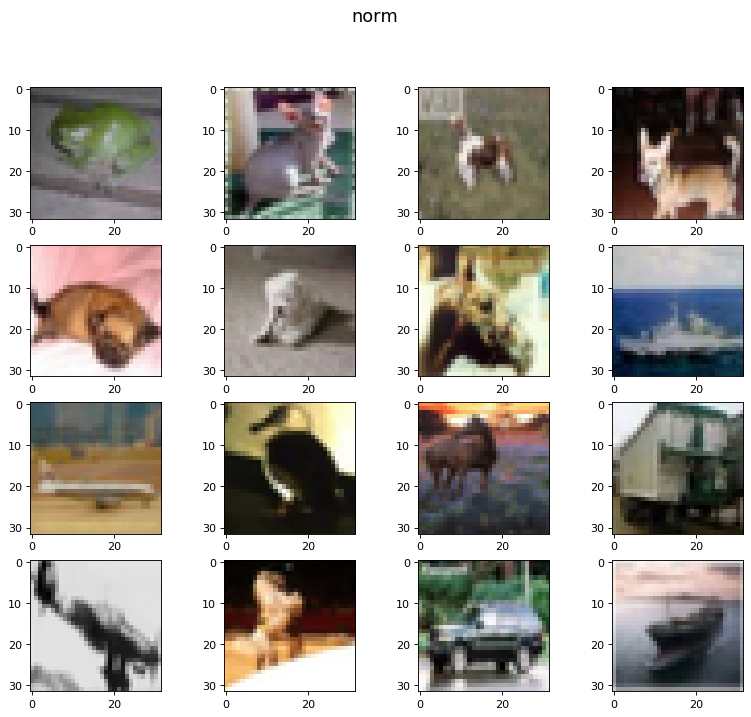

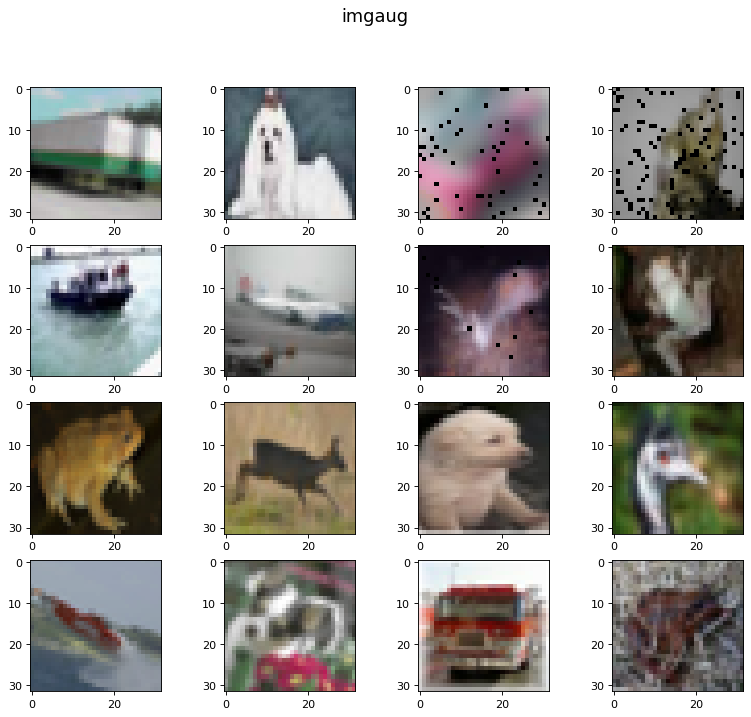

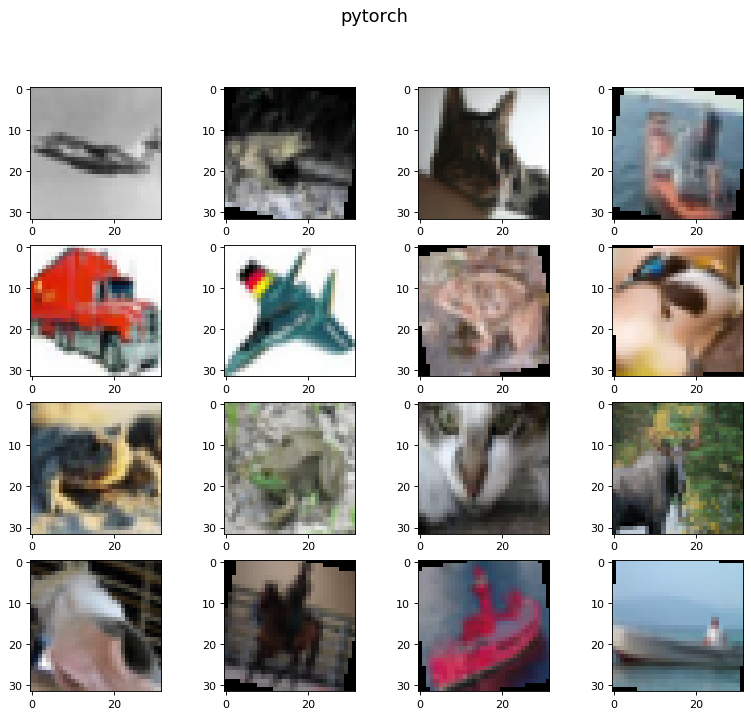

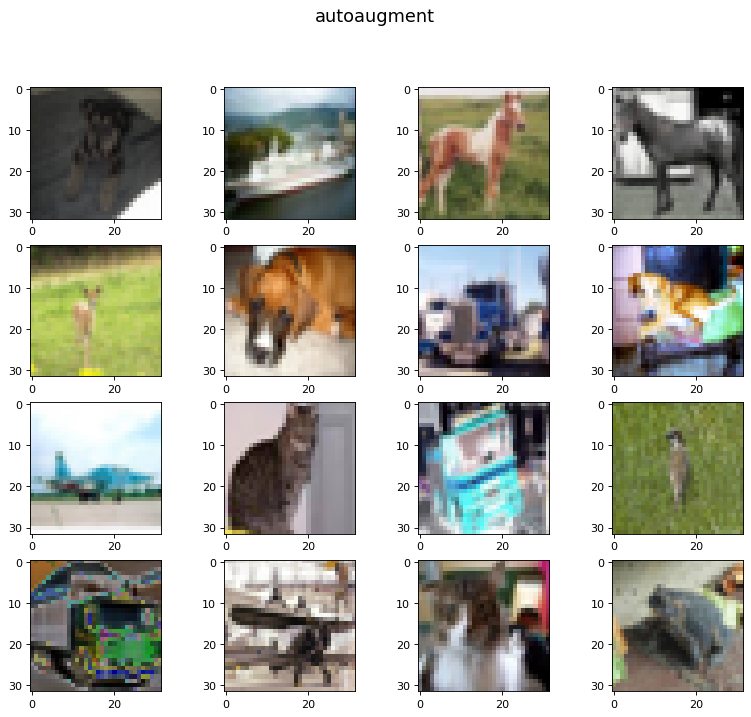

In [21]:

n=16

for key in ppds_trainsets:
    loader = get_preprocessed_train_loader(1, ppds_trainsets[key])
    dataiter = iter(loader)
    plotSomeImages(n, dataiter, key)

In [ ]:
import time
import torch.optim as optim
import numpy as np


def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.CrossEntropyLoss()
    #loss = torch.nn.NLLLoss()
    
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

def trainNet(net, dataset_name, trainset, batch_size, n_epochs, learning_rate):
    
    training_losses = {}
    validation_losses = {}
    
    type_name = dataset_name

    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("trainset=", type_name)
    

    #train_loader = get_train_loader(batch_size, trainset)
    train_loader = get_preprocessed_train_loader(1, trainset)
    
    print("Length train loader (batches)= " + str(len(train_loader)))
    print("=" * 30)
    
    n_batches = len(train_loader)

    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)

    #Create a multi step elarning rate
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=np.linspace(10,n_epochs, 10), gamma=0.1)

    #Time for printing
    training_start_time = time.time()

    training_losses = []
    validation_losses = []

    total_train_loss = 0

    #Loop for n_epochs
    for j, epoch in enumerate(range(n_epochs), 0):

        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        #total_train_loss = 0
        
        
        #for i, data in enumerate(trainset, 0):
        for i, data in enumerate(train_loader, 0):
            
            
            #Get inputs
            #inputs, labels = data
            inputs = data[0][0]
            labels = data[1][0]
            



            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            #Set the parameter gradients to zero
            optimizer.zero_grad()

            #Forward pass, backward pass, optimize
            outputs = net(inputs)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            

            #Print statistics

            running_loss += loss_size.data
            total_train_loss += loss_size.data


            training_losses.append(total_train_loss / ((j * n_batches) + (i+1)))


            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()

        #At the end of the epoch, do a pass on the validation set


        #val_loader = torch.utils.data.DataLoader(trainsets[key], batch_size=128, sampler=val_sampler, num_workers=2)
        val_loader = test_loader
        total_val_loss = 0
        for inputs, labels in val_loader:

            #Wrap tensors in Variables
            inputs, labels = Variable(inputs), Variable(labels)

            inputs = inputs.to(device)
            labels = labels.to(device)

            #Forward pass
            val_outputs = net(inputs)
            val_loss_size = loss(val_outputs, labels)
            total_val_loss += val_loss_size.data

        #Learning rate step
        scheduler.step()

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

        validation_losses.append(total_val_loss / len(val_loader))

        print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
        

    return training_losses, validation_losses
    
        

# Train the network

In [ ]:
import torchvision.models as models

resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

all_training_losses = {}
all_validation_losses = {}

for key in ppds_trainsets:
    model = SmallNet()
    #model = resnet18

    model = model.cuda(device)
    training_losses, validation_losses = trainNet(model, key, ppds_trainsets[key], batch_size=BATCH_SIZE, n_epochs=N_EPOCHS, learning_rate=LEARNING_RATE)
    all_training_losses[key] = training_losses
    all_validation_losses[key] = validation_losses




===== HYPERPARAMETERS =====
batch_size= 32
epochs= 30
learning_rate= 0.001
trainset= norm
Length train loader (batches)= 625
Epoch 1, 10% 	 train_loss: 2.29 took: 0.32s
Epoch 1, 20% 	 train_loss: 1.88 took: 0.33s
Epoch 1, 30% 	 train_loss: 1.82 took: 0.31s
Epoch 1, 40% 	 train_loss: 1.73 took: 0.31s
Epoch 1, 50% 	 train_loss: 1.73 took: 0.33s
Epoch 1, 60% 	 train_loss: 1.68 took: 0.33s
Epoch 1, 70% 	 train_loss: 1.64 took: 0.33s
Epoch 1, 80% 	 train_loss: 1.65 took: 0.32s
Epoch 1, 90% 	 train_loss: 1.61 took: 0.32s
Validation loss = 1.59
Training finished, took 7.13s
Epoch 2, 10% 	 train_loss: 1.49 took: 0.32s
Epoch 2, 20% 	 train_loss: 1.53 took: 0.31s
Epoch 2, 30% 	 train_loss: 1.53 took: 0.31s
Epoch 2, 40% 	 train_loss: 1.50 took: 0.31s
Epoch 2, 50% 	 train_loss: 1.46 took: 0.31s
Epoch 2, 60% 	 train_loss: 1.45 took: 0.31s
Epoch 2, 70% 	 train_loss: 1.47 took: 0.31s
Epoch 2, 80% 	 train_loss: 1.43 took: 0.32s
Epoch 2, 90% 	 train_loss: 1.43 took: 0.32s
Validation loss = 1.45
Trainin

# Results compared

Text(0.5, 1.0, 'Validation loss')

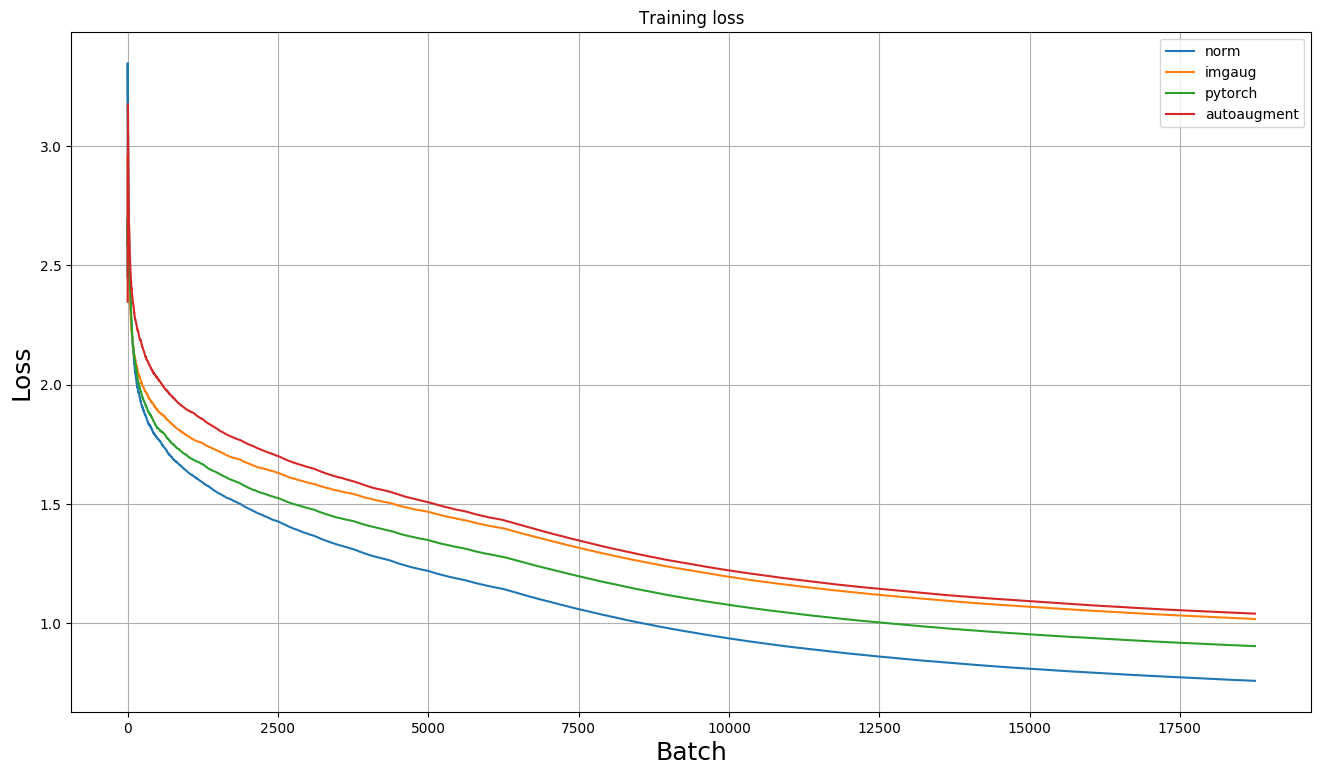

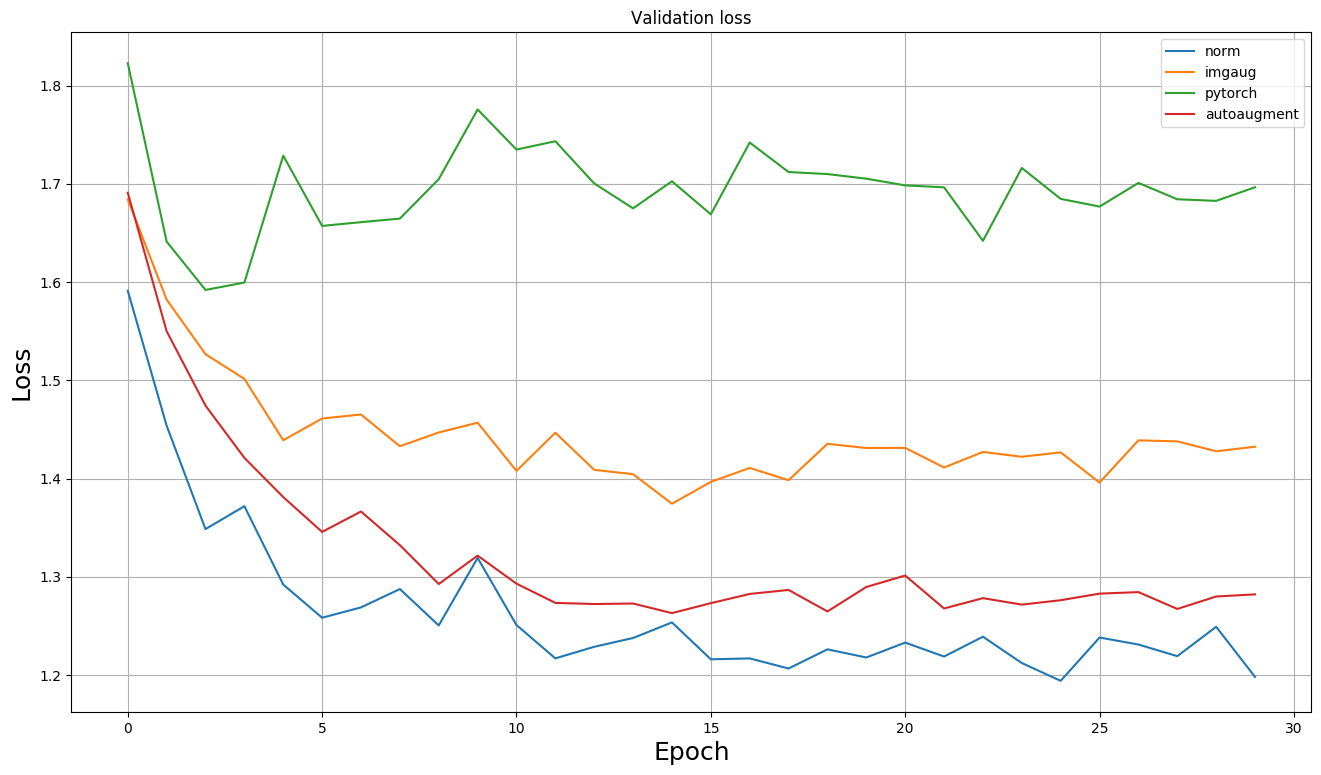

In [ ]:
plt.figure(1, figsize=(16, 9), dpi=100)
for key in all_training_losses:
    plt.plot(all_training_losses[key])
plt.xlabel('Batch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid()
plt.legend(all_training_losses.keys())
plt.title('Training loss')
                                                      
plt.figure(2, figsize=(16, 9), dpi=100)
for key in all_validation_losses:
    plt.plot(all_validation_losses[key])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.grid()
plt.grid(which='minor')
plt.legend(all_validation_losses.keys())
plt.title('Validation loss')

In [ ]:
classes = test_loader.dataset.classes

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = CNN(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

# TODO:

#TODOS:
- MultiStepLR learning rate anpassen?
- augmentations preprocessing damit es doch auf colab trainieren kann, oder schneller trainiert.
- albumentations hinzufuegen

#imgaug
#autoaugment
#fast autoaugment
#PBA? population based?
# Cycle GAN?

#neuro augment (aus paper?)

# Fragen

- generelle Vorgehensweise (pytorch, imgaug, autoaugment, (neuroaugment aus paper) ? oder reicht da nur es zu erwähnen?)
- Was für ein Netz, reicht das SmallNet?
- sind cifar10 daten ok?